In [1]:
from tensorly.decomposition.candecomp_parafac import *
# from tensorly.decomposition import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF,non_negative_factorization
from tensorly.kruskal_tensor import *
from glob import glob 

In [2]:
df_test = pd.read_csv('./PARAFAC implementation/Testing Data/K036VRÁS-RS211.csv',index_col=0)
df_test.index = pd.DatetimeIndex(df_test.CTime)
df_test = df_test.loc[df_test.OkPct >= 98]
df_test = df_test.loc[df_test.Flag == 524480]


In [3]:
x = df_test.loc[(df_test.CType == 4) & (df_test.Val > 0),:].Val
x = x.resample('1h').mean()
x = x.fillna(method='ffill')
weekhour_index = x.index.weekday * 24 + x.index.hour
first_0 = np.argwhere(weekhour_index == 0)[0,0]
last_0 = np.argwhere(weekhour_index == 0)[-1,0]
x = x.iloc[first_0:last_0]
X = x.values.reshape((-1,7*24))

In [4]:
X = X.reshape(-1,24*7)

In [5]:
X.shape

(683, 168)

In [6]:
from scipy.optimize import nnls
def predict_one_week(b,y):
    # Solve the problem of xb = y
    
    x = nnls(b,y,)
    return x[0]

def get_strides_and_shift(array,window = 168):   
    n = array.shape[0] - window + 1
    arr_strided = np.lib.stride_tricks.as_strided(array, shape=[n, window], strides=2*array.strides)
    shifts = np.arange(0,len(arr_strided))%168
    return arr_strided,shifts

In [7]:
model_list = []

In [8]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

C:\Users\sverrirhd\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
# NMF(n_components=3,init='random',max_iter = 10000,tol=1e-10,).fit_transform(X)

In [10]:
from sklearn.decomposition._cdnmf_fast import _update_cdnmf_fast
from sklearn.utils.validation import  _deprecate_positional_args,check_is_fitted, check_non_negative
from sklearn.utils import check_random_state, check_array
import numbers

from sklearn.utils.extmath import randomized_svd, safe_sparse_dot, squared_norm
# from ..utils.validation import check_is_fitted, check_non_negative

In [11]:
def _compute_regularization(alpha, l1_ratio, regularization):
    """Compute L1 and L2 regularization coefficients for W and H"""
    alpha_H = 0.
    alpha_W = 0.
    if regularization in ('both', 'components'):
        alpha_H = float(alpha)
    if regularization in ('both', 'transformation'):
        alpha_W = float(alpha)

    l1_reg_W = alpha_W * l1_ratio
    l1_reg_H = alpha_H * l1_ratio
    l2_reg_W = alpha_W * (1. - l1_ratio)
    l2_reg_H = alpha_H * (1. - l1_ratio)
    return l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H

In [12]:
def _check_init(A, shape, whom):
    A = check_array(A)
    if np.shape(A) != shape:
        raise ValueError('Array with wrong shape passed to %s. Expected %s, '
                         'but got %s ' % (whom, shape, np.shape(A)))
    check_non_negative(A, whom)
    if np.max(A) == 0:
        raise ValueError('Array passed to %s is full of zeros.' % whom)

In [13]:
def _check_string_param(solver, regularization, beta_loss, init):
    allowed_solver = ('cd', 'mu')
    if solver not in allowed_solver:
        raise ValueError(
            'Invalid solver parameter: got %r instead of one of %r' %
            (solver, allowed_solver))

    allowed_regularization = ('both', 'components', 'transformation', None)
    if regularization not in allowed_regularization:
        raise ValueError(
            'Invalid regularization parameter: got %r instead of one of %r' %
            (regularization, allowed_regularization))

    # 'mu' is the only solver that handles other beta losses than 'frobenius'
    if solver != 'mu' and beta_loss not in (2, 'frobenius'):
        raise ValueError(
            'Invalid beta_loss parameter: solver %r does not handle beta_loss'
            ' = %r' % (solver, beta_loss))

    if solver == 'mu' and init == 'nndsvd':
        warnings.warn("The multiplicative update ('mu') solver cannot update "
                      "zeros present in the initialization, and so leads to "
                      "poorer results when used jointly with init='nndsvd'. "
                      "You may try init='nndsvda' or init='nndsvdar' instead.",
                      UserWarning)

In [14]:
def _fit_coordinate_descent(X, W, H, tol=1e-4, max_iter=200, l1_reg_W=0,
                            l1_reg_H=0, l2_reg_W=0, l2_reg_H=0, update_H=True,
                            verbose=0, shuffle=False, random_state=None):
    
    """Compute Non-negative Matrix Factorization (NMF) with Coordinate Descent
    The objective function is minimized with an alternating minimization of W
    and H. Each minimization is done with a cyclic (up to a permutation of the
    features) Coordinate Descent.
    Parameters
    ----------
        X : array-like, shape (n_samples, n_features)
            Constant matrix.
        W : array-like, shape (n_samples, n_components)
            Initial guess for the solution.
        H : array-like, shape (n_components, n_features)
            Initial guess for the solution.
        tol : float, default: 1e-4
            Tolerance of the stopping condition.
        max_iter : integer, default: 200
            Maximum number of iterations before timing out.
        l1_reg_W : double, default: 0.
            L1 regularization parameter for W.
        l1_reg_H : double, default: 0.
            L1 regularization parameter for H.
        l2_reg_W : double, default: 0.
            L2 regularization parameter for W.
        l2_reg_H : double, default: 0.
            L2 regularization parameter for H.
        update_H : boolean, default: True
            Set to True, both W and H will be estimated from initial guesses.
            Set to False, only W will be estimated.
        verbose : integer, default: 0
            The verbosity level.
        shuffle : boolean, default: False
            If true, randomize the order of coordinates in the CD solver.
        random_state : int, RandomState instance, default=None
            Used to randomize the coordinates in the CD solver, when
            ``shuffle`` is set to ``True``. Pass an int for reproducible
            results across multiple function calls.
            See :term:`Glossary <random_state>`.
        Returns
        -------
        W : array-like, shape (n_samples, n_components)
            Solution to the non-negative least squares problem.
        H : array-like, shape (n_components, n_features)
            Solution to the non-negative least squares problem.
        n_iter : int
            The number of iterations done by the algorithm.
        References
        ----------
        Cichocki, Andrzej, and Phan, Anh-Huy. "Fast local algorithms for
        large scale nonnegative matrix and tensor factorizations."
        IEICE transactions on fundamentals of electronics, communications and
        computer sciences 92.3: 708-721, 2009.
    """
    # so W and Ht are both in C order in memory
    Ht = check_array(H.T, order='C')
    X = check_array(X, accept_sparse='csr')

    rng = check_random_state(random_state)
    
    for n_iter in range(1, max_iter + 1):
        violation = 0.

        # Update W
        violation += _update_coordinate_descent(X, W, Ht, l1_reg_W,
                                                l2_reg_W, shuffle, rng)
        # Update H
        if update_H:
            violation += _update_coordinate_descent(X.T, Ht, W, l1_reg_H,
                                                    l2_reg_H, shuffle, rng)
            Ht[:,0] = np.ones((Ht.shape[0]))
            Ht = Ht/np.linalg.norm(Ht,axis=0).reshape(1,-1)
            
        if n_iter == 1:
            violation_init = violation

        if violation_init == 0:
            break

        if verbose:
            print("violation:", violation / violation_init)

        if violation / violation_init <= tol:
            if verbose:
                print("Converged at iteration", n_iter + 1)
            break
    return W, Ht.T, n_iter


def _update_coordinate_descent(X, W, Ht, l1_reg, l2_reg, shuffle,
                               random_state):
    """Helper function for _fit_coordinate_descent
    Update W to minimize the objective function, iterating once over all
    coordinates. By symmetry, to update H, one can call
    _update_coordinate_descent(X.T, Ht, W, ...)
    """
    n_components = Ht.shape[1]

    HHt = np.dot(Ht.T, Ht)
    XHt = safe_sparse_dot(X, Ht)

    # L2 regularization corresponds to increase of the diagonal of HHt
    if l2_reg != 0.:
        # adds l2_reg only on the diagonal
        HHt.flat[::n_components + 1] += l2_reg
    # L1 regularization corresponds to decrease of each element of XHt
    if l1_reg != 0.:
        XHt -= l1_reg

    if shuffle:
        permutation = random_state.permutation(n_components)
    else:
        permutation = np.arange(n_components)
    # The following seems to be required on 64-bit Windows w/ Python 3.5.
    permutation = np.asarray(permutation, dtype=np.intp)
    return _update_cdnmf_fast(W, HHt, XHt, permutation)


@_deprecate_positional_args
def custom_NMF_update(X, W=None, H=None, n_components=None, *,
                               init=None, update_H=True, solver='cd',
                               beta_loss='frobenius', tol=1e-4,
                               max_iter=200, alpha=0., l1_ratio=0.,
                               regularization=None, random_state=None,
                               verbose=0, shuffle=False):
    
    r"""Compute Non-negative Matrix Factorization (NMF)
    Find two non-negative matrices (W, H) whose product approximates the non-
    negative matrix X. This factorization can be used for example for
    dimensionality reduction, source separation or topic extraction.
    The objective function is::
        0.5 * ||X - WH||_Fro^2
        + alpha * l1_ratio * ||vec(W)||_1
        + alpha * l1_ratio * ||vec(H)||_1
        + 0.5 * alpha * (1 - l1_ratio) * ||W||_Fro^2
        + 0.5 * alpha * (1 - l1_ratio) * ||H||_Fro^2
    Where::
        ||A||_Fro^2 = \sum_{i,j} A_{ij}^2 (Frobenius norm)
        ||vec(A)||_1 = \sum_{i,j} abs(A_{ij}) (Elementwise L1 norm)
    For multiplicative-update ('mu') solver, the Frobenius norm
    (0.5 * ||X - WH||_Fro^2) can be changed into another beta-divergence loss,
    by changing the beta_loss parameter.
    The objective function is minimized with an alternating minimization of W
    and H. If H is given and update_H=False, it solves for W only.
    Parameters
    ----------
        X : array-like, shape (n_samples, n_features)
            Constant matrix.
        W : array-like, shape (n_samples, n_components)
            If init='custom', it is used as initial guess for the solution.
        H : array-like, shape (n_components, n_features)
            If init='custom', it is used as initial guess for the solution.
            If update_H=False, it is used as a constant, to solve for W only.
        n_components : integer
            Number of components, if n_components is not set all features
            are kept.
        init : None | 'random' | 'nndsvd' | 'nndsvda' | 'nndsvdar' | 'custom'
            Method used to initialize the procedure.
            Default: None.
            Valid options:
            - None: 'nndsvd' if n_components < n_features, otherwise 'random'.
            - 'random': non-negative random matrices, scaled with:
                sqrt(X.mean() / n_components)
            - 'nndsvd': Nonnegative Double Singular Value Decomposition (NNDSVD)
                initialization (better for sparseness)
            - 'nndsvda': NNDSVD with zeros filled with the average of X
                (better when sparsity is not desired)
            - 'nndsvdar': NNDSVD with zeros filled with small random values
                (generally faster, less accurate alternative to NNDSVDa
                for when sparsity is not desired)
            - 'custom': use custom matrices W and H
            .. versionchanged:: 0.23
                The default value of `init` changed from 'random' to None in 0.23.
        update_H : boolean, default: True
            Set to True, both W and H will be estimated from initial guesses.
            Set to False, only W will be estimated.
        solver : 'cd' | 'mu'
            Numerical solver to use:
            - 'cd' is a Coordinate Descent solver that uses Fast Hierarchical
                Alternating Least Squares (Fast HALS).
            - 'mu' is a Multiplicative Update solver.
            .. versionadded:: 0.17
               Coordinate Descent solver.
            .. versionadded:: 0.19
               Multiplicative Update solver.
        beta_loss : float or string, default 'frobenius'
            String must be in {'frobenius', 'kullback-leibler', 'itakura-saito'}.
            Beta divergence to be minimized, measuring the distance between X
            and the dot product WH. Note that values different from 'frobenius'
            (or 2) and 'kullback-leibler' (or 1) lead to significantly slower
            fits. Note that for beta_loss <= 0 (or 'itakura-saito'), the input
            matrix X cannot contain zeros. Used only in 'mu' solver.
            .. versionadded:: 0.19
        tol : float, default: 1e-4
            Tolerance of the stopping condition.
        max_iter : integer, default: 200
            Maximum number of iterations before timing out.
        alpha : double, default: 0.
            Constant that multiplies the regularization terms.
        l1_ratio : double, default: 0.
            The regularization mixing parameter, with 0 <= l1_ratio <= 1.
            For l1_ratio = 0 the penalty is an elementwise L2 penalty
            (aka Frobenius Norm).
            For l1_ratio = 1 it is an elementwise L1 penalty.
            For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
        regularization : 'both' | 'components' | 'transformation' | None
            Select whether the regularization affects the components (H), the
            transformation (W), both or none of them.
        random_state : int, RandomState instance, default=None
            Used for NMF initialisation (when ``init`` == 'nndsvdar' or
            'random'), and in Coordinate Descent. Pass an int for reproducible
            results across multiple function calls.
            See :term:`Glossary <random_state>`.
        verbose : integer, default: 0
            The verbosity level.
        shuffle : boolean, default: False
            If true, randomize the order of coordinates in the CD solver.
        Returns
        -------
        W : array-like, shape (n_samples, n_components)
            Solution to the non-negative least squares problem.
        H : array-like, shape (n_components, n_features)
            Solution to the non-negative least squares problem.
        n_iter : int
            Actual number of iterations.
        Examples
        --------
        >>> import numpy as np
        >>> X = np.array([[1,1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
        >>> from sklearn.decomposition import non_negative_factorization
        >>> W, H, n_iter = non_negative_factorization(X, n_components=2,
        ... init='random', random_state=0)
        References
        ----------
        Cichocki, Andrzej, and P. H. A. N. Anh-Huy. "Fast local algorithms for
        large scale nonnegative matrix and tensor factorizations."
        IEICE transactions on fundamentals of electronics, communications and
        computer sciences 92.3: 708-721, 2009.
        Fevotte, C., & Idier, J. (2011). Algorithms for nonnegative matrix
        factorization with the beta-divergence. Neural Computation, 23(9).
    """
    X = check_array(X, accept_sparse=('csr', 'csc'),
                    dtype=[np.float64, np.float32])
    check_non_negative(X, "NMF (input X)")
    beta_loss = _check_string_param(solver, regularization, beta_loss, init)

    if X.min() == 0 and beta_loss <= 0:
        raise ValueError("When beta_loss <= 0 and X contains zeros, "
                         "the solver may diverge. Please add small values to "
                         "X, or use a positive beta_loss.")

    n_samples, n_features = X.shape
    if n_components is None:
        n_components = n_features

    if not isinstance(n_components, numbers.Integral) or n_components <= 0:
        raise ValueError("Number of components must be a positive integer;"
                         " got (n_components=%r)" % n_components)
    if not isinstance(max_iter, numbers.Integral) or max_iter < 0:
        raise ValueError("Maximum number of iterations must be a positive "
                         "integer; got (max_iter=%r)" % max_iter)
    if not isinstance(tol, numbers.Number) or tol < 0:
        raise ValueError("Tolerance for stopping criteria must be "
                         "positive; got (tol=%r)" % tol)

    # check W and H, or initialize them
    if init == 'custom' and update_H:
        _check_init(H, (n_components, n_features), "NMF (input H)")
        _check_init(W, (n_samples, n_components), "NMF (input W)")
        if H.dtype != X.dtype or W.dtype != X.dtype:
            raise TypeError("H and W should have the same dtype as X. Got "
                            "H.dtype = {} and W.dtype = {}."
                            .format(H.dtype, W.dtype))
    elif not update_H:
        _check_init(H, (n_components, n_features), "NMF (input H)")
        if H.dtype != X.dtype:
            raise TypeError("H should have the same dtype as X. Got H.dtype = "
                            "{}.".format(H.dtype))
        # 'mu' solver should not be initialized by zeros
        if solver == 'mu':
            avg = np.sqrt(X.mean() / n_components)
            W = np.full((n_samples, n_components), avg, dtype=X.dtype)
        else:
            W = np.zeros((n_samples, n_components), dtype=X.dtype)
    else:
        W, H = _initialize_nmf(X, n_components, init=init,
                               random_state=random_state)

    l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H = _compute_regularization(
        alpha, l1_ratio, regularization)

    if solver == 'cd':
        W, H, n_iter = _fit_coordinate_descent(X, W, H, tol, max_iter,
                                               l1_reg_W, l1_reg_H,
                                               l2_reg_W, l2_reg_H,
                                               update_H=update_H,
                                               verbose=verbose,
                                               shuffle=shuffle,
                                               random_state=random_state)
        print(f'{n_iter} iterations before convergence')
    elif solver == 'mu':
        W, H, n_iter = _fit_multiplicative_update(X, W, H, beta_loss, max_iter,
                                                  tol, l1_reg_W, l1_reg_H,
                                                  l2_reg_W, l2_reg_H, update_H,
                                                  verbose)

    else:
        raise ValueError("Invalid solver parameter '%s'." % solver)

    if n_iter == max_iter and tol > 0:
        warnings.warn("Maximum number of iterations %d reached. Increase it to"
                      " improve convergence." % max_iter, ConvergenceWarning)

    return W, H, n_iter

In [15]:
best_dict = {}
from sklearn.base import BaseEstimator
class NMF_custom(BaseEstimator):
    
    def __init__(self,
                 X=None,
                 n_components=3,
                 max_iter=10000,
                 tol = 1e-10,
                 return_error = False,
#                  beta_loss = 'kullback-leibler',
#                  solver='mu',
                 beta_loss = 'frobenius',
                 solver='cd',
                 alpha=0.0,                   
                 l1_ratio=0.0,
                 regularization='components',
                 name = 'Custom NMF implementation with a single flat profile',
                 errors = []):
        
        self.params = {
            'n_components' : n_components,
            'max_iter' : max_iter,
            'tol' : tol,
            'beta_loss' : beta_loss,
            'solver' : solver,
            'alpha' : alpha,
            'l1_ratio' : l1_ratio,
            'regularization' : regularization,
            'name':'Custom NMF implementation with a single flat profile',
            
        }
        
        self.errors = []
            
    

    @ignore_warnings(category=ConvergenceWarning)    
    def compute_NMF_step(self,update_H=True,iters=1000):
        self.W, self.H, _ = custom_NMF_update(X = self.X,
                                             W = self.W,
                                             H = self.H,
                                             n_components=self.params['n_components'],
                                             init='custom',
                                             update_H=update_H,
                                             solver=self.params['solver'],
                                             beta_loss=self.params['beta_loss'],
                                             tol=self.params['tol'],
                                             max_iter=iters,
                                             alpha=self.params['alpha'],
                                             l1_ratio=self.params['l1_ratio'],
                                             regularization=self.params['regularization'],
                                             random_state=None,
                                             verbose=0,
                                             shuffle=False)
        
        
    def get_params(self,deep=False):
        return self.params
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.params[parameter] = value
            
        return self
    
    def fit(self,data,y=None):
        
        
        self.X = data
        self.p = self.X.shape[1]
        
        
        self.n,self.p = self.X.shape
        
        self.H = np.abs(np.random.normal(0,1,(self.params['n_components'],168)))
        self.W = np.abs(np.random.normal(0,1,(self.n, self.params['n_components'])))

        

        self.compute_NMF_step(update_H=True,iters=self.params['max_iter'])
        self.components_ = self.H
        
        
    def fit_transform(self,data,y=None):
        self.fit(data)
        return self.transform(data)
        
    
    def estimate_abundances(self,data):
        n_comp = self.params['n_components']
        X_re_min = np.array([predict_one_week(self.H.T,y).reshape(1,n_comp) for y in data]).squeeze()
        return X_re_min
    
    def transform(self,data):
        n_comp = self.params['n_components']
        X_re_min = np.array([predict_one_week(self.H.T,y).reshape(1,n_comp)@self.H for y in data]).squeeze()
        return X_re_min
    
        
    def decompose(self,data):
        n_comp = self.params['n_components']
        factors = []
        for i in range(self.params['n_components']):
            fac = np.array([predict_one_week(self.H.T,y).reshape(1,n_comp)[:,i]*self.H[i] for y in data]).ravel()
            factors.append(fac)
            
        return np.array(factors).T
    
    def predict_leak(self,data):
        n_comp = self.params['n_components']
        leak_prediction = np.array([predict_one_week(self.H.T,y).reshape(1,n_comp)[:,0]*self.H[0] for y in data]).ravel()
        return leak_prediction
    
    def predict(self,data):
        return self.transform(data)
    
    def get_profiles(self,n):
        address = './hyperparameter tuning results/profiles/'
        files = glob(address + f'*_{n}.csv')
        if n in best_dict.keys():
            return best_dict[n]
        
        if len(files) == 0:
            return np.abs(np.random.normal(0,1,(self.params['n_components'],168)))
        
        mses = []
        for f in files:
            mse = np.float(f[len(address):].split('_')[0])
            mses.append(mse)
        best_profiles = files[np.argmin(mses)]
        profiles = pd.read_csv(best_profiles,index_col=0).values
        best_dict[n] = profiles
        return profiles
    
    def write_profiles(self,profiles,mse):
        address = './hyperparameter tuning results/profiles/'
        n = self.params['n_components']
        files = glob(address + f'*_{n}.csv')
        n_comps = profiles.shape[0]
        if len(files) > 0:
            mses = []
            for f in files:
                tmp_mse = np.float(f[len(address):].split('_')[0])
                mses.append(tmp_mse)
            if np.min(mses) > mse:
                pd.DataFrame(profiles).to_csv(f'{address}{mse}_{n_comps}.csv')
                best_dict[n_comps] = profiles
        else:
            best_dict[n_comps] = profiles
            pd.DataFrame(profiles).to_csv(f'{address}{mse}_{n_comps}.csv')

            
    

In [16]:
nmf_custom = NMF_custom(X,max_iter=10000,tol=10e-12,n_components=3)
nmf_custom.fit(X)
# plt.plot(nmf_custom.errors)


10000 iterations before convergence


In [20]:
abundances = nmf_custom.decompose(X)

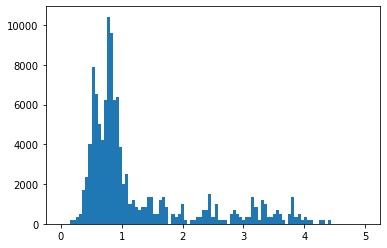

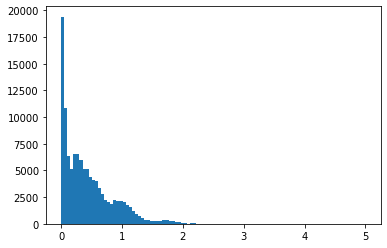

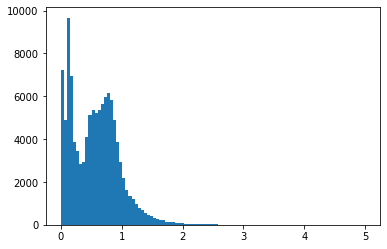

In [28]:
plt.hist(abundances[:,0],bins = np.linspace(0,5,100));plt.show()
plt.hist(abundances[:,1],bins = np.linspace(0,5,100));plt.show()
plt.hist(abundances[:,2],bins = np.linspace(0,5,100));plt.show()

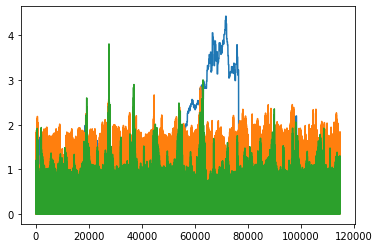

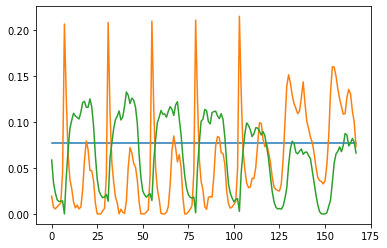

In [17]:
X_re_built_in_transform = nmf_custom.transform(X)
plt.plot(nmf_custom.decompose(X))
plt.show()
plt.plot(nmf_custom.components_.T)
plt.show()

In [ ]:
from sklearn.utils.estimator_checks import check_estimator
# check_estimator(NMF_custom)

In [ ]:
W = nmf_custom.nmf.transform(X)
H = nmf_custom.nmf.components_
X_re = W@H

X_re_min = np.array([predict_one_week(H.T,y).reshape(1,12)@H for y in X]).ravel()

In [ ]:
MSE_re = np.mean((X.ravel() - X_re.ravel())**2)
# MSE_re_inv = np.mean((X.ravel() - X_inv.ravel())**2)
MSE_re_min = np.mean((X.ravel() - X_re_min.ravel())**2)

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(X.ravel(),alpha=0.5)
plt.plot(X_re.ravel(),alpha=.5)
# plt.plot(X_inv.ravel(),alpha=.5)
plt.plot(X_re_min.ravel(),alpha=.5)
plt.legend(['original','WH','LstSq'])

In [ ]:
print(MSE_re)
# print(MSE_re_inv)
print(MSE_re_min)

In [ ]:
print(MSE_re)
# print(MSE_re_inv)
print(MSE_re_min)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
from sklearn.metrics import make_scorer,mean_squared_error
neg_mean_squared_error_scorer = make_scorer(mean_squared_error,greater_is_better=False)


In [ ]:
# nmf_tmp = NMF_custom(None,3,100,1e-10,False,'kullback-leibler','mu',0.0,0.0)
# nmf_tmp.fit(X)
# print(neg_mean_squared_error_scorer(nmf_tmp,X,X_re))

# nmf_tmp = NMF_custom(None,3,100,1e-10,False,'kullback-leibler','mu',0.5,100)
# nmf_tmp.fit(X)
# print(neg_mean_squared_error_scorer(nmf_tmp,X,X_re))

In [ ]:
n,p = X.shape
n_train = n//2
X_train,X_test = X[:n_train],X[n_train:]

n_components = np.arange(4,10,1)
alpha = np.linspace(0,30,11)
l1_ratio = np.linspace(0,1,4)
regularization = ['both', 'components']

param_grid = {
     'n_components':n_components,
     'alpha':alpha,
     'l1_ratio':l1_ratio,
     'regularization':regularization,
}

splits = TimeSeriesSplit(max_train_size=None, n_splits=3)

In [ ]:
# for i,j in splits.split(X):
#     print(i)

In [ ]:
param_grid

In [ ]:
nmf_custom = NMF_custom(max_iter=1000,
                        beta_loss = 'frobenius',
                        solver='cd',)

search = GridSearchCV(nmf_custom,
                      param_grid,
                      scoring=neg_mean_squared_error_scorer,
                      n_jobs=-1,
                      iid='deprecated',
                      refit=True,
                      cv=splits, 
                      verbose=3,
                      pre_dispatch='2*n_jobs',
                      error_score='raise',
                      return_train_score=True)

In [ ]:
# search.fit(X,X)

In [ ]:
search.cv_results_

In [ ]:
# def save_results(cv_res):
#     import datetime as dt
#     fields = [x for x in cv_res.keys() if 'score' in x]
#     data = np.array([cv_res[t] for t in fields])
#     result_df = pd.DataFrame(data.T,index=cv_res['params'],columns=fields)
#     time_now = dt.datetime.now()
#     date_string = time_now.strftime(format='%Y_%m_%d_%H%M%S')
#     result_df.to_csv(f'./hyperparameter tuning results/{date_string}.csv')

# save_results(search.cv_results_)

In [ ]:
performance = search.cv_results_['mean_test_score']

In [ ]:
np.max(performance)

In [ ]:
search.best_params_

In [ ]:
# search.b

In [ ]:
performance_tensor = performance.reshape(tuple(len(tmp) for tmp in param_grid.values()))

In [ ]:
tmp = [1,2,3]
tmp.remove(1)
tmp

In [ ]:
for i,param in enumerate(param_grid.keys()):
    axes = list(np.arange(4))
    axes.remove(i)
    plt.plot(list(param_grid[param]),np.mean(performance_tensor,axis=tuple(axes)))
    plt.xlabel(param)
    plt.show()

In [ ]:
search.best_params_

In [ ]:
# nmf_custom = NMF_custom(X=None,
#                         n_components=3,
#                         max_iter=30000,
#                         tol = 1e-20,
#                         return_error = True,
#                         beta_loss = 'frobenius',
#                         solver='cd',
#                         alpha=7.5,                   
#                         l1_ratio=1,
#                         regularization='components',
#                         name = 'Custom NMF implementation with a single flat profile',
#                         errors = []
#                        )
# nmf_custom.fit(X)

In [ ]:
nmf_custom = NMF_custom(X=None,
                        n_components=12,
                        max_iter=10000,
                        tol = 1e-10,
                        return_error = True,
                        beta_loss = 'frobenius',
                        solver='cd',
                        alpha=10,                   
                        l1_ratio=1,
                        regularization='components',
                        name = 'Custom NMF implementation with a single flat profile',
                        errors = []
                       )
nmf_custom.fit(X)

In [ ]:
# plt.plot(-np.diff(nmf_custom.errors))
# plt.yscale('log')

In [ ]:
compoenents = nmf_custom.nmf.components_

In [ ]:
X_re_min = np.array([predict_one_week(compoenents.T,y).reshape(1,-1)@compoenents for y in X]).ravel()
X_re_built_in = nmf_custom.transform(X)

In [ ]:
plt.plot(X.ravel(),alpha=0.5)
plt.plot(X_re_built_in,alpha=0.5)
plt.plot(X_re_min,alpha=0.5)

In [ ]:
residuals = X_re_min-X.ravel()
plt.hist(residuals,bins=np.arange(-5,5,0.1))
plt.show()

In [ ]:
from scipy.stats import kurtosis
kurtosis(residuals)

In [ ]:
print('mse:',np.mean(residuals**2))
print('mae:',np.mean(np.abs(residuals)))

In [ ]:
print('mse:',np.mean(residuals**2))
print('mae:',np.mean(np.abs(residuals)))

In [ ]:
# df = pd.read_csv('./PARAFAC implementation/Testing data/combined_sensor_data_average_ok_values.csv')

In [ ]:
# sensors_of_interst = ['K-RVK-003-RS211',
#                       'K-RVK-013-RS211',
#                       'K-RVK-020-RS211',
#                       'K-RVK-019-RS221',
#                       'K-RVK-035-RS211',
#                       'K-RVK-036-RS211',
#                       'K-RVK-038-RS211',
#                       'K-RVK-040-RS211',
#                       'K-RVK-040-RS221',
#                       'K-RVK-040-RS241',
#                       'K-RVK-044-RS241',
#                       'K-RVK-045-RS211',
#                       'K-RVK-045-RS221',
#                       'K-RVK-046-RS221',
#                       'K-RVK-049-RS221',
#                       'K-RVK-053-RS211',
#                       'K-RVK-055-RS231']
    

In [ ]:
# clean_sensor_dict = {}
# problem_sensor_dict = {}
# for sensor in sensors_of_interst:    
#     subset = df.loc[df.Name == sensor].dropna()
#     subset.index = pd.DatetimeIndex(subset.CTime)
#     subset = subset.loc[subset.Val > 0]
#     std = subset.Val.std()
#     mean = subset.Val.mean()
#     subset = subset.loc[(subset.Val < mean+4*std) &
#                         (subset.Val > mean-4*std)]
#     print(len(subset))
#     print(mean,std)
#     try:
#         x = subset.Val
#         x = x.resample('1h').mean()
#         x = x.fillna(method='ffill',limit = 5)
#         weekhour_index = x.index.weekday * 24 + x.index.hour
#         first_0 = np.argwhere(weekhour_index == 0)[0,0]
#         last_0 = np.argwhere(weekhour_index == 0)[-1,0]
#         x = x.iloc[first_0:last_0]
#         X = x.values.reshape((-1,7,24))
        
#         clean_sensor_dict[sensor] = X
#     except:
#         print(sensor)
#         print(subset)
#         problem_sensor_dict[sensor] = df.loc[df.Name == sensor].dropna()

In [ ]:
component_abundances.sum(0)

In [ ]:
W

In [117]:
nmf_custom = NMF_custom(3)
nmf_custom.fit(X)

10000 iterations before convergence


In [118]:
W = nmf_custom.estimate_abundances(X)
H = nmf_custom.components_

In [ ]:
leak_dict = {
    dt.date(2019,8, 1):['Fáfnisnes 24','Meðal'],
    dt.date(2019,6, 4):['Bauganes 3','Lítill'],
    dt.date(2016,7,14):['Bauganes 19','Lítill'],              
    dt.date(2011,2,28):['Skildinganes 4','Meðal'],
    dt.date(2013,8,24):['Skildinganes 19','Meðal'],
    dt.date(2014,1,30):['Skildinganes 33','Meðal'],
}
leak_dict_2 = {
    # More leaks
    dt.date(2010,7,1): ['',''],
    dt.date(2010,6,7): ['',''],
    dt.date(2019,7,1): ['',''],
    dt.date(2010,5,27):['',''],
    dt.date(2017,10,6):['',''],
    dt.date(2007,6,11):['',''],
    dt.date(2011,2,24):['',''],
    dt.date(2013,6,24):['',''],
    dt.date(2014,1,17):[],
    dt.date(2020,1,21):[],
    dt.date(2020,1,21):[],
#     dt.date(2014,,17):[]
}
